In [6]:
import pandas as pd
import statsmodels

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import set_config
set_config(transform_output = 'pandas')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# sns.set_theme('notebook')
# sns.set_palette('Set2')

plt.rcParams['figure.figsize'] = (12, 8)

In [8]:
df = pd.read_csv('data/AirPassengers.zip', parse_dates=['Month'], index_col='Month')
df

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


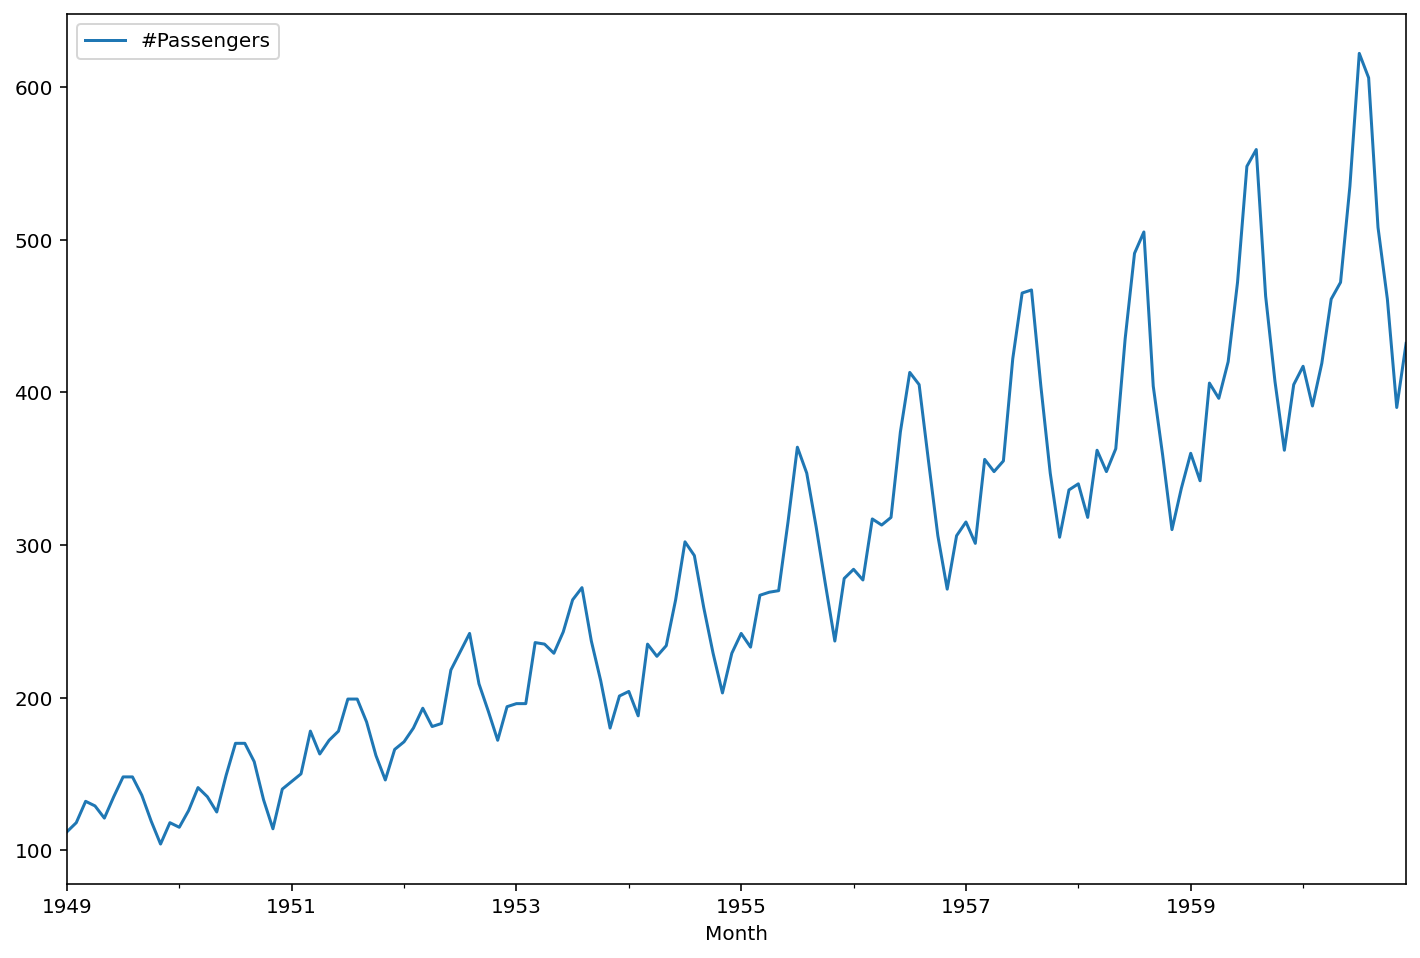

In [12]:
df.plot();

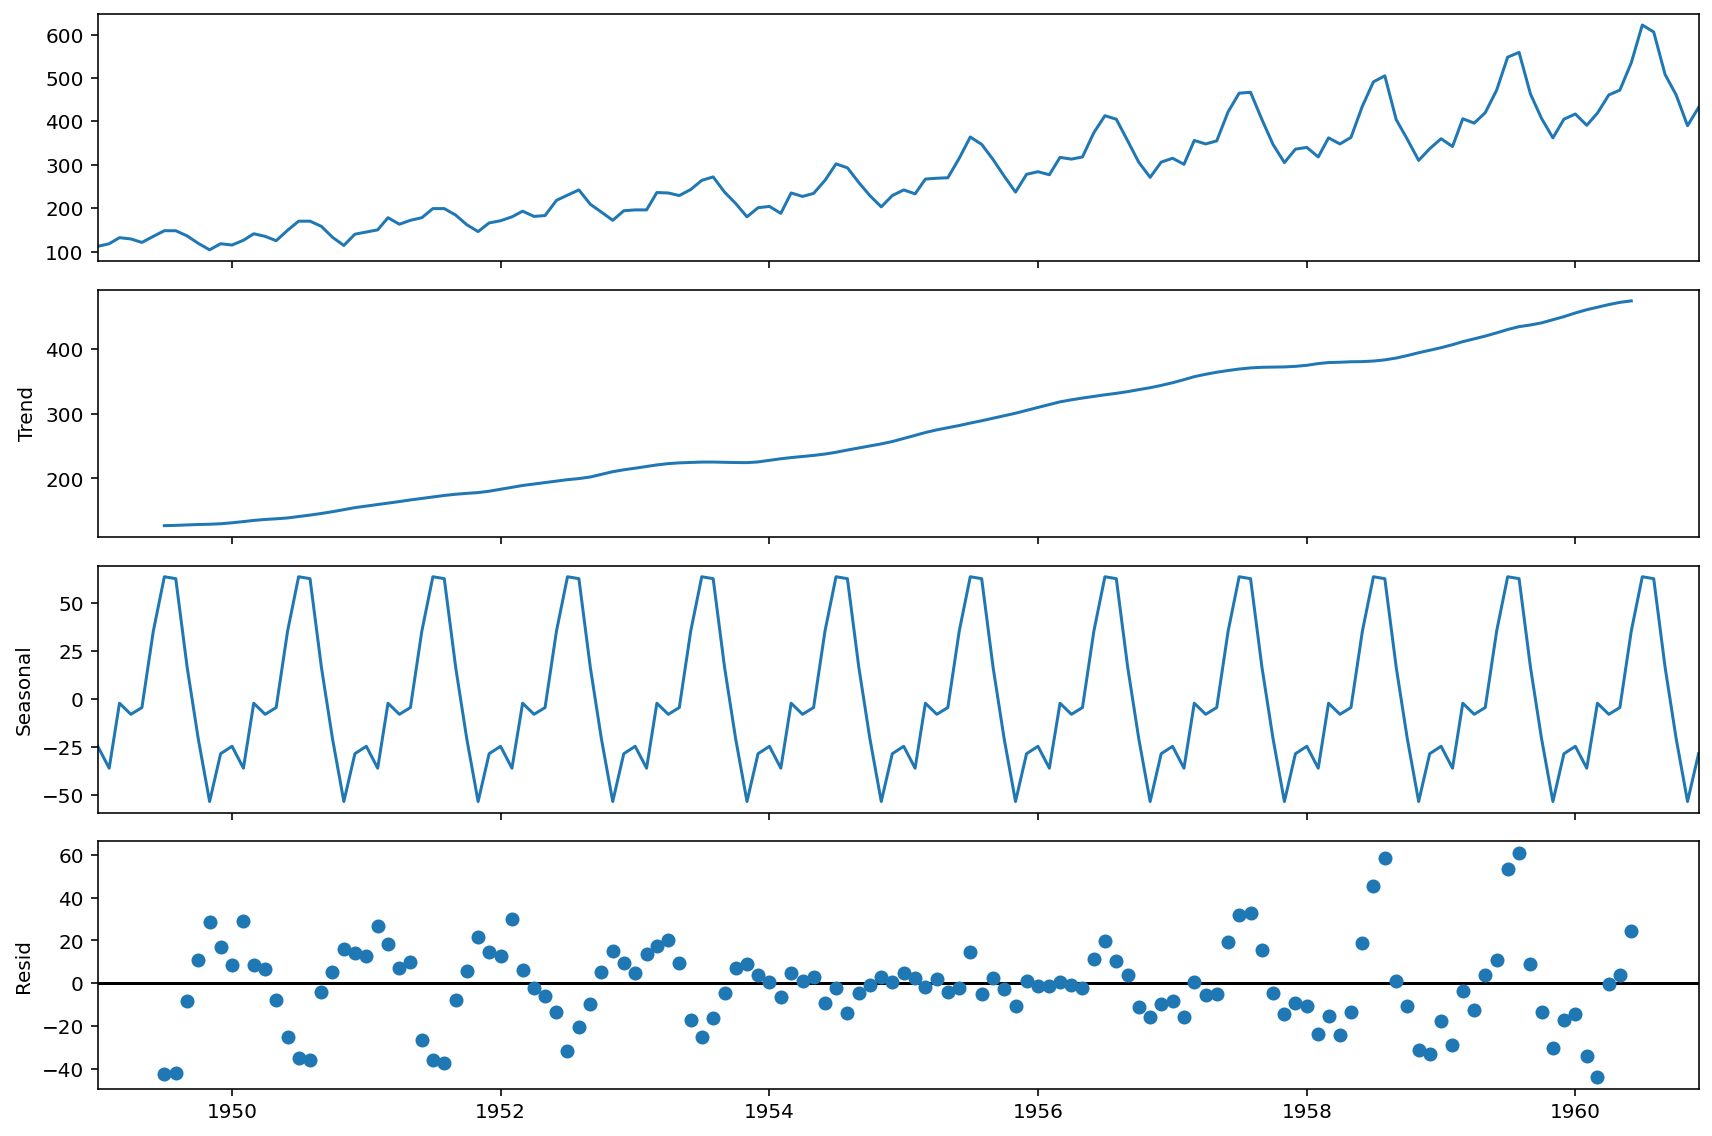

In [9]:
# импортируем библиотеку 
from statsmodels.tsa.seasonal import seasonal_decompose
# производим декомпозицию временного ряда 
decomposition = seasonal_decompose(df)
fig = decomposition.plot()
plt.show()